In [1]:
#Importing Libraries
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',500)
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error,r2_score

In [3]:
df=pd.read_excel(r"C:\Users\nisha\OneDrive\Desktop\GREAT LEARNING COURSES\Shinakshi Didi Material\Financial Transaction Volume Prediction\REGNANDATA.xlsx")


In [4]:
#Reading Data
df=pd.read_excel(r"C:\Users\nisha\OneDrive\Desktop\GREAT LEARNING COURSES\Shinakshi Didi Material\Financial Transaction Volume Prediction\REGNANDATA.xlsx",parse_dates=[0])

In [5]:
df.head()

,year,Credit Card POS Count,Debit Card POS Count,RTGS,NEFT
0,2015-01-01,17947247.0,11151245.0,889032.0,16342282.0
1,2015-02-01,15602279.0,10288412.0,865068.0,19244474.0
2,2015-03-01,NaN,11582587.0,1072737.0,26906303.0
3,2015-04-01,18188579.0,12044987.0,895710.0,17862349.0
4,2015-05-01,19313259.0,13368953.0,NaN,21496984.0


In [6]:
#Checking for null values
df.isnull().sum()

year                     0
Credit Card POS Count    6
Debit Card POS Count     4
RTGS                     5
NEFT                     8
dtype: int64

In [7]:
#Imputing Missing values with mean
df.fillna(df.mean(),inplace=True)

In [8]:
df.isnull().sum() #Missing values are treated

year                     0
Credit Card POS Count    0
Debit Card POS Count     0
RTGS                     0
NEFT                     0
dtype: int64

In [9]:
df['Total_transactions']=df['Credit Card POS Count']+df['Debit Card POS Count']+df['RTGS']+df['NEFT']

In [10]:
df.head()

,year,Credit Card POS Count,Debit Card POS Count,RTGS,NEFT,Total_transactions
0,2015-01-01,1.794725e+07,11151245.0,8.890320e+05,16342282.0,4.632981e+07
1,2015-02-01,1.560228e+07,10288412.0,8.650680e+05,19244474.0,4.600023e+07
2,2015-03-01,3.273981e+07,11582587.0,1.072737e+06,26906303.0,7.230144e+07
3,2015-04-01,1.818858e+07,12044987.0,8.957100e+05,17862349.0,4.899162e+07
4,2015-05-01,1.931326e+07,13368953.0,1.149440e+06,21496984.0,5.532864e+07


In [11]:
df.drop(['Credit Card POS Count','Debit Card POS Count','RTGS','NEFT'],inplace=True,axis=1)

In [12]:
df.head()

,year,Total_transactions
0,2015-01-01,4.632981e+07
1,2015-02-01,4.600023e+07
2,2015-03-01,7.230144e+07
3,2015-04-01,4.899162e+07
4,2015-05-01,5.532864e+07


In [13]:
df.describe()

,Total_transactions
count,6.000000e+01
mean,8.900457e+07
std,2.341117e+07
min,4.600023e+07
25%,6.802919e+07
50%,9.422284e+07
75%,1.071568e+08
max,1.356472e+08


In [14]:
print('Time Period Starts: {}\nTime Period Ends: {}'.format(df.year.min(),df.year.max()))

Time Period Starts: 2015-01-01 00:00:00
Time Period Ends: 2019-12-01 00:00:00


In [15]:
df.columns

Index(['year', 'Total_transactions'], dtype='object')

In [16]:
df.shape

(60, 2)

In [17]:
df.set_index('year',inplace=True)
df.head()

,Total_transactions
year,
2015-01-01,4.632981e+07
2015-02-01,4.600023e+07
2015-03-01,7.230144e+07
2015-04-01,4.899162e+07
2015-05-01,5.532864e+07


### Decompose using statsmodel
We can use statsmodels to perform a decomposition.
It deconstructs a time series into several components, each representing one of the underlying categories of patterns.
With statsmodels we will be able to see the trend, seasonality, and residual components of our data.

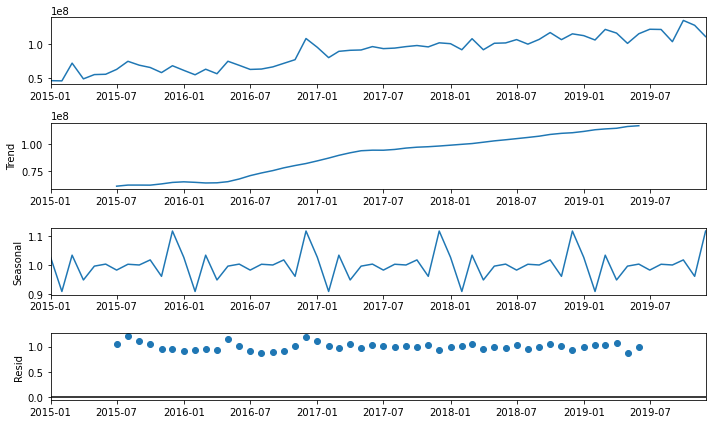

In [18]:
plt.rcParams['figure.figsize']=[10,6]
decomposition=sm.tsa.seasonal_decompose(df,model='multiplicative')
a=decomposition.plot()
plt.show()

In [19]:
# Original data plot have increasing pattern
# Can be clearly seen that trend was constant till mid 2016 and then started increasing and then slightly decreasing and then increasing only
# In seasonal plot, we can see transactions increase in december each year 
# Residuals have more fluctuations till 2017 , after that its not increasing much thus they are less only

### Stationarity

Stationary means that statistical properties such as mean, variance remain constant over time.

Most of the Time Series models work on the assumption that the Time series is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.

Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

### Check for stationarity

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.

Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [20]:
### Plotting rolling statistics

In [21]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Total_transactions'])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

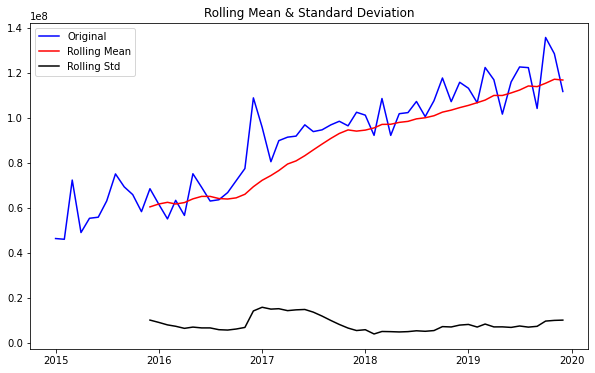

Results of Dickey-Fuller Test:
Test Statistic                 -0.674172
p-value                         0.853327
Lags Used                       2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [22]:
test_stationarity(df)

### We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
The time series is hence not stationary

Augmented Dickey-Fuller Test

The intuition behind the test is that if the series is integrated then the lagged level of the series df4(t-1) will provide no relevant information in predicting the change in df4(t).

Null hypothesis: The time series is not stationary.
Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

and as p value is greater than 0.05 so we fail to reject the H0 and hence time series is not stationary

### Making Time Series Stationary
There are 2 major reasons behind non-stationaruty of a TS:

Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.


### Differencing:

In this technique, we take the difference of the observation at a particular instant with that at the previous instant.

First order differencing in Pandas

In [23]:
ts_diff=df-df.shift()
ts_diff.head()

,Total_transactions
year,
2015-01-01,NaN
2015-02-01,-3.295730e+05
2015-03-01,2.630120e+07
2015-04-01,-2.330981e+07
2015-05-01,6.337011e+06


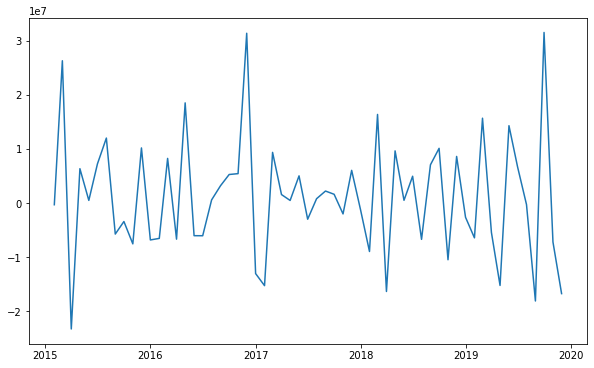

In [24]:
plt.plot(ts_diff)

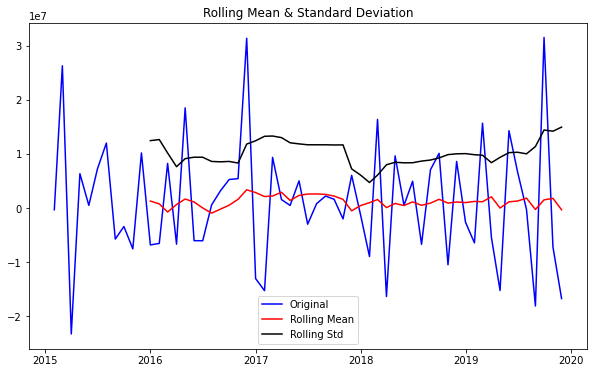

Results of Dickey-Fuller Test:
Test Statistic                -9.974610e+00
p-value                        2.194391e-17
Lags Used                      1.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64


In [25]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

In [26]:
# Since p value is is less than 0.05 so we reject null hypothesis and therefore time series is stationery

# Decomposition
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.


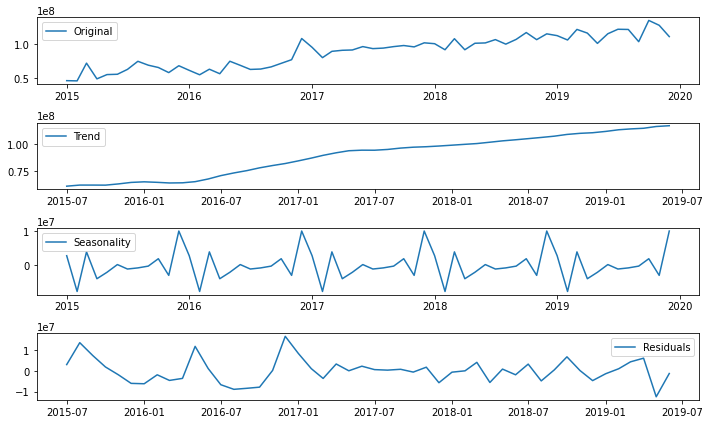

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Autoregressive Integrated Moving Average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


### Observations from EDA on the time series:

Non stationarity implies at least one level of differencing (d) is required in ARIMA

The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
Tuning ARIMA parameters

A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [28]:
ts = df.Total_transactions - df.Total_transactions.shift()
ts.dropna(inplace=True) # taking the difference between actual series and series obtained by shifting one value

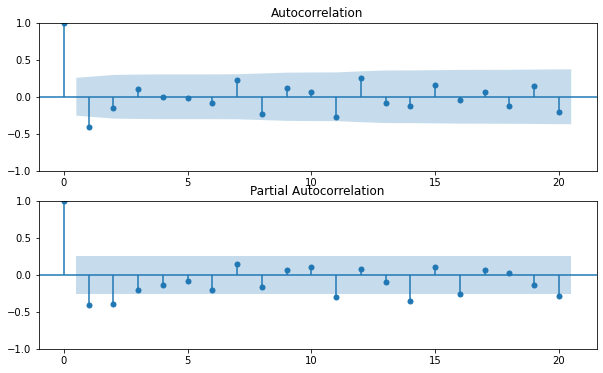

In [29]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=20)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=20)
pyplot.show()
# as acf plot have 2nd lag negative ie data is stationary now

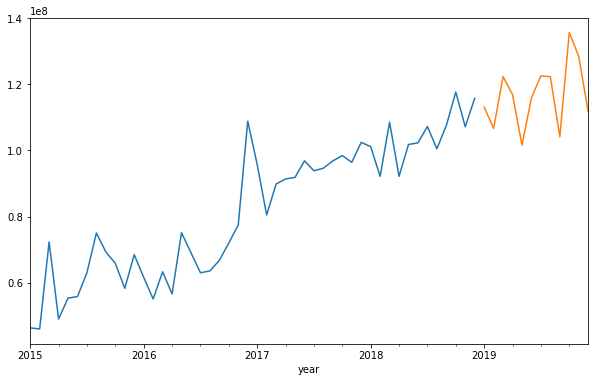

In [30]:
#divide into train and validation set
train = df[:int(0.80*(len(df)))]
valid = df[int(0.80*(len(df))):]

#plotting the data
train['Total_transactions'].plot()
valid['Total_transactions'].plot() # splitting the data into 80:20
plt.show()

In [31]:
# ARIMA example
#from statsmodels.tsa.arima import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     Total_transactions   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -823.407
Date:                Sun, 26 Mar 2023   AIC                           1652.813
Time:                        14:19:25   BIC                           1658.364
Sample:                    01-01-2015   HQIC                          1654.902
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5644      0.201     -2.804      0.005      -0.959      -0.170
ma.L1          0.3159      0.256      1.236      0.216      -0.185       0.817
sigma2      7.443e+13   4.35e-15   1.71e+28      0.0

C:\Users\nisha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nisha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nisha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [33]:
mse = mean_squared_error(df[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 10165337.977402577, MSE:103334096194823.12


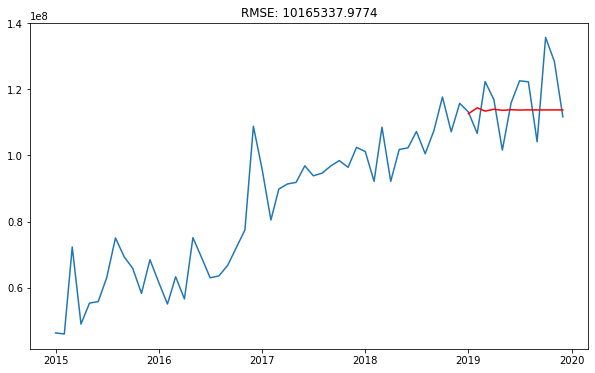

In [34]:
plt.plot(df.Total_transactions)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()